# Notebook: F6 -- Decision Tress and Bagging

*Authors*: Hugo Toll, Paul Häusner<br>
*Date*: Nov 2023

This notebook is complementary to lecture F6 about Decision Trees, Bagging, Random Forests and Boosting. This notebook is intended to highlight some key concepts regarding Decision Trees and Bagging. The focus will be on:

1. Different splitting criteria: **Missclassification rate**, **Gini index** and **Entropy**.
2. Understanding **recursive binary splitting**
3. How **bagging** works and why it is used



Please read the instructions and play around with the notebook where it is described.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

---
# 1. Generating data

Below, data used for binary classification with two input variables is generated. The boundary between the classes is given by a sine curve. The chosen class labels -1 and 1 correspond to blue and red datapoints respectively.
As you can see, some data points are wrongly labelled.


Please run the code to generate the dataset.

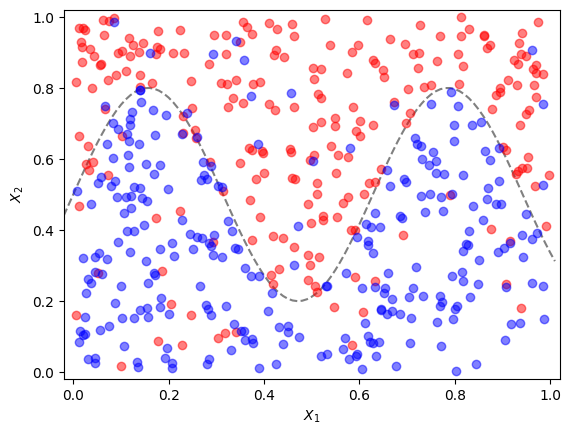

In [2]:
n = 500 # Number of datapoints
np.random.seed(42) # fix seed for reproducible results

def generate_data(n):
    X_data = np.random.uniform(0, 1, size=(n,2)) # [[x1,x2],...]
    y_data = np.empty(n)
    for i in range(n):
        if X_data[i,1] < (0.5+0.3*np.sin(10*X_data[i,0])):
            y_data[i] = -1 #The class labels are -1 and 1
        else:
            y_data[i] = 1
        r = np.random.random()
        if r > 0.9: # Change classes for 10% of the datapoints
            y_data[i] *= -1
    return X_data, y_data

# Generate data
X_data, y_data = generate_data(n)
# plot the data together with the sine curve
fig, ax = plt.subplots()
ax.set_xlim((-0.02, 1.02))
ax.set_ylim((-0.02, 1.02))

x_sin = np.arange(-0.02, 1.02, 0.01)
y_sin = 0.5+0.3*np.sin(10*x_sin)

ax.plot(x_sin, y_sin, '--', color ='grey')
ax.plot(X_data[:,0][y_data==1], X_data[:,1][y_data==1], 'o', color='r', alpha=0.5)
ax.plot(X_data[:,0][y_data==-1], X_data[:,1][y_data==-1], 'o', color='b', alpha=0.5)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
plt.show()

---

# 2. Decision Trees

Decision Trees divides the input spate into $L$ regions called $R_l$. Each region is associated with a constant prediction $\hat{y}_l$. This prediction can be a numerical value (regression) or a categorical value (classification).

The regions and their associated predictions can be learned from data using an algorithm called recursive binary splitting. It recursively divides the input space into two half-spaces and assigns the predictions $\hat{y}_l$ to these regions, using for example a majority vote. It is a greedy algorithm, meaning that the loss is minimized in each step and not for the complete tree.

Below, three common splitting criteria (loss functions) for recursive binary splitting are shown as well as a figure comparing them.

In [3]:
def miss_class_rate(y):
    # Calculates the miss classification rate for a binary classification dataset
    red_share = len(y[y==1])/len(y)
    blue_share = len(y[y==-1])/len(y)
    return 1- max(red_share, blue_share)

def entropy(y):
    # Calculates the entropy for a binary classification dataset
    red_share = len(y[y==1])/len(y)
    blue_share = len(y[y==-1])/len(y)
    if red_share==0 or blue_share==0:
        return 0
    return -(red_share*np.log(red_share)+blue_share*np.log(blue_share))

def gini_index(y):
    # Calculates the gini index for a binary classification dataset
    red_share = len(y[y==1])/len(y)
    blue_share = len(y[y==-1])/len(y)
    return red_share*(1-red_share) + blue_share*(1-blue_share)


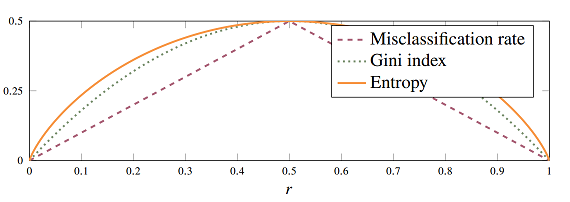

This figure is taken from the coursebook (Machine Learning - A First Course for Engineers and Scientists, p. 34) and compares the three splitting criteria. The x-axis shows the proportion of the first class in a certain region (called r) and the y-axis shows the associated loss. Note that the entropy criteria has been scaled.

**Questions**:

*  Which splitting criteria favours pure regions (r close to 0 or 1) the most?

*  Is favouring pure regions disproportionally a good thing in recursive binary splitting? Why/ Why not?


In the next two code cells we perform recursive binary splitting. Run them and then go to the next text cell for the tasks. Make sure all earlier code cells have been executed.

1) The Entropy favours the pure regions the most as the loss increases the fastest as you step away from the pure regions.
2) Not disproportionaly, that would lead to overfitting, if we for example only end up with one training point in each leaf. Favouring pure regions could also lead to favouring of one feature unproportionally over another, leading to bias.

In [10]:
def majority_vote(y):
    if len(y[y==1]) > len(y)/2:
        majority = 1
    else:
        majority = -1
    return majority


def split(X, y, R, Regions, Pred, loss_calc, depth=0):
  # Used in recursive binary splitting to compute regions for a decision tree
    if depth >= max_depth or len(X) < 2*min_points or loss_calculator(y) == 0:
        # Stop recursive splitting, save the region and the associated prediction.
        Regions.append(R)
        Pred.append(majority_vote(y))
    else:
        #Compute the optimal binary split of the region R
        loss = np.ones((len(X), 2))*np.inf #Large value as default value
        for j in range(2): # 2 input variables in this case
            for i in range(len(X)): # iterate over all possible splits in the data
                X_over = X[X[:,j]>X[i,j]]
                y_over = y[X[:,j]>X[i,j]]
                X_under = X[X[:,j]<=X[i,j]]
                y_under = y[X[:,j]<=X[i,j]]
                if len(y_over)<min_points or len(y_under)<min_points:
                    continue
                loss[i,j] = len(y_under)*loss_calc(y_under) + len(y_over)*loss_calc(y_over)

        optimal_index = np.argmin(loss)
        j = optimal_index % 2 # optimal splitting variable
        i = optimal_index // 2 # datapoint corresponding to the optimal split

        # execute the optimal split
        X_over = X[X[:,j]>X[i,j]]
        y_over = y[X[:,j]>X[i,j]]
        R_over = [el.copy() for el in R]
        R_over[j][0] = X[i,j]
        X_under = X[X[:,j]<=X[i,j]]
        y_under = y[X[:,j]<=X[i,j]]
        R_under = [el.copy() for el in R]
        R_under[j][1] = X[i,j]

        # Continue splitting the new regions until stopping criteria is satisfied
        split(X_over, y_over, R_over, Regions, Pred, loss_calc, depth+1)
        split(X_under, y_under, R_under, Regions, Pred, loss_calc, depth+1)
        return


def learn_tree(X, y, loss_func):
    # Performs recursive binary splitting to train a decision tree
    R=[[0,1],[0,1]]
    regions = []
    predictions = []
    split(X, y, R, regions, predictions, loss_func)
    return regions, predictions

In [5]:
def tree_predict(X, regions, predictions):
    pred = []
    for el in X:
        for r in regions:
            if r[0][1] >= el[0] > r[0][0] and r[1][1] >= el[1] > r[1][0]:
                pred.append(predictions[regions.index(r)])
    return pred

def accuracy(X, y, predicter, regions, pred):
    predictions = np.array(predicter(X, regions, pred))
    acc = len(predictions[predictions == y])/len(y)
    return acc

def plot_boundary(Xdata, ydata, predicter, regions, pred):
    #plots the decision boundary together with training data
    fig, ax = plt.subplots()
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    res = 0.015   # resolution of the squares
    xs1 = np.arange(0.001, 1, res)
    xs2 = np.arange(0.001, 1, res)
    x1, x2 = np.meshgrid(xs1, xs2)
    X_all = np.column_stack([x1.flatten(),x2.flatten()])
    prediction = np.array(predicter(X_all, regions, pred))
    colors = np.where(prediction==1,'lightsalmon', 'skyblue')
    ax.scatter(x1.flatten(), x2.flatten(), s = 90, marker='s', c=colors)
    ax.plot(Xdata[:,0][ydata==1], Xdata[:,1][ydata==1], 'o', color='r', alpha=0.5)
    ax.plot(Xdata[:,0][ydata==-1], Xdata[:,1][ydata==-1], 'o', color='b', alpha=0.5)
    plt.show()

**Tasks**:

The function split() in the code cell above computes and performs the optimal binary split of the provided data given a certain loss function. Read through the code to answer the following question:
* How does the binary splitting algorithm decide which split is the best?
It choose the splitting that reduces the impurity the most

Now run the code cell below and inspect the resulting plot. Here we see the training data and the prediction regrions of our model.
* Is the bias of this model high or low?
* Is the variance high or low?

Tune the model until you are happy with the result. Using the three indicated tuning variables: max_depth, min_points, loss_calculator.
* Is it theoretically possible to obtain a 100 % classification accuracy on the test data of this dataset?
* What test accuracy did you achieve?

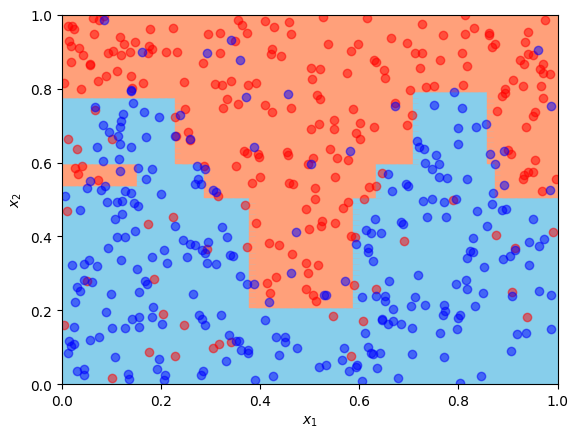

Training accuracy: 0.874
Test accuracy: 0.8418


In [50]:
# CHANGE THE FOLLOWING VARIABLES:
max_depth = 14 # maximum depth of the tree
min_points = 6 # minimum number of points in a region
loss_calculator = miss_class_rate # write the name of the chosen loss function. Your options are:
                                  # miss_class_rate, gini_index or entropy

# The following part learns a decision tree and plots the result
regions, pred = learn_tree(X_data, y_data, loss_calculator)
plot_boundary(X_data, y_data, tree_predict, regions, pred)

# calculate training and test accuracy
train_acc = accuracy(X_data, y_data, tree_predict, regions, pred)
print(f'Training accuracy: {train_acc}')

X_test, y_test = generate_data(n=10000)
test_acc = accuracy(X_test, y_test, tree_predict, regions, pred)
print(f'Test accuracy: {test_acc}')

---

# 3. Bagging
A fully grown decision tree (max depth) suffers from high variance but has low bias as you could see in the previous task. A method that can be used to decrease the variance of a model without increasing its bias is bagging. Bagging is therefore often used with deep decision trees as base models.

The idea of bagging is to average over multiple base models learned from different datasets obtained via a process called bootstrapping. Below, a fully grown decision tree is trained on a single bootstrapped dataset.

**Task**: Run the code and inspect the results.



In [51]:
# create bootstraped dataset
def bootstrap(X, y):
    bootstrapped_X = np.empty_like(X)
    bootstrapped_y = np.empty_like(y)
    for i in range(len(y)):
        l = np.random.randint(0,len(y))
        bootstrapped_X[i,:] = X[l,:]
        bootstrapped_y[i] = y[l]
    return bootstrapped_X, bootstrapped_y

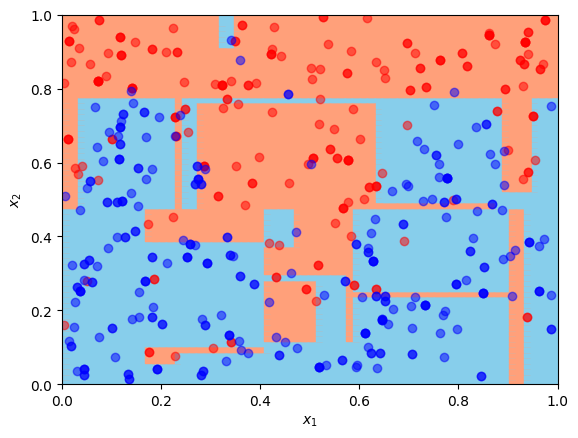

Accuracy on the bootstrapped dataset: 1.0
Accuracy on training data: 0.916
Accuracy on test data: 0.7744


In [52]:
# Hyper-parameters for a single ensemble member are fixed
max_depth = 100
min_points = 1
loss_calculator = gini_index

# bootstrap the data
X_boot, y_boot = bootstrap(X_data, y_data)

#learn a model on the bootstrapped data
regions, pred = learn_tree(X_boot, y_boot, loss_calculator)

# plot decision boundaries together with bootstrapped data
plot_boundary(X_boot, y_boot, tree_predict, regions, pred)

# calculate training and test accuracy
bootstrap_acc = accuracy(X_boot, y_boot, tree_predict, regions, pred)
print(f'Accuracy on the bootstrapped dataset: {bootstrap_acc}')
train_acc = accuracy(X_data, y_data, tree_predict, regions, pred)
print(f'Accuracy on training data: {train_acc}')
test_acc = accuracy(X_test, y_test, tree_predict, regions, pred)
print(f'Accuracy on test data: {test_acc}')

Above, a single so called ensemble member was constructed. Now we will perform the actual bagging by first constructing $B=20$ unique ensemble members and then averaging their results to obtain a prediction.

**Tasks**:
* Try out different values for the number of base models $B$ in the code below
* Is the bias of the ensamble model high or low compared to a single ensable member as seen above? What about the variance of the ensable model?

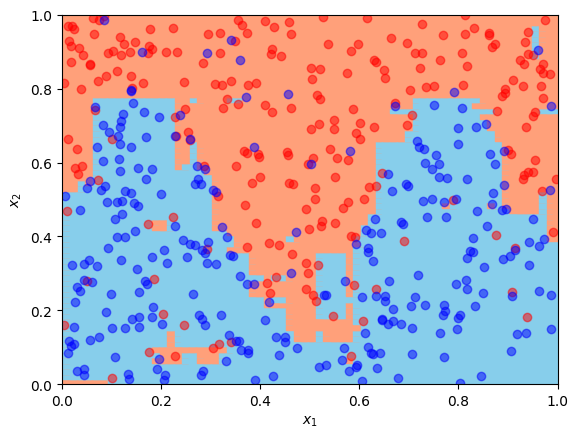

Accuracy on training data: 1.0
Accuracy on test data: 0.8429


In [53]:
# Number of base models used
B = 100

def bagging(X, y, model, B):
    b_regions = []
    b_pred = []
    for b in range(B):
        X_boot, y_boot = bootstrap(X, y)
        r, p = model(X_boot, y_boot, loss_calculator)
        b_regions.append(r)
        b_pred.append(p)
    return b_regions, b_pred

def bagging_predict(X, b_regions, b_pred):
    average_preds = []
    pred = []
    for el in X:
        for b in range(B):
            pred.append(tree_predict([el], b_regions[b], b_pred[b]))
        average_preds.append(np.sign(np.sum(pred)))
        pred = []
    return average_preds

b_regions, b_pred = bagging(X_data, y_data, learn_tree, B)
plot_boundary(X_data, y_data, bagging_predict, b_regions, b_pred)

# Calculate training and test accuracy
train_acc = accuracy(X_data, y_data, bagging_predict, b_regions, b_pred)
print(f'Accuracy on training data: {train_acc}')
test_acc = accuracy(X_test, y_test, bagging_predict, b_regions, b_pred)
print(f'Accuracy on test data: {test_acc}')

---

# Take-home message

* Decision trees are trained via recursive binary splitting, which is a greedy algorithm.
* Other splitting criteria than missclassification rate, for example gini index and entropy, can improve the results of the training
* Bagging can be used on a basemodel to reduce variance without increasing bias.

**Recommendation for further reading:** The material covered in this notebook is well-covered in Chapter 2.3 (Decision Trees) and Chapter 7.1 (Bagging) in the coursebook *Machine Learning - A First Course for Engineers and Scientists*.